# Association Rule Mining with Record Data (REKT Database)

## Introduction

For ARM analysis, we shall use the cleaned REKT Database that we used for classification analysis. Like clustering analysis, ARM does not require a response variable beacuse it is an unsupervised machine learning method. However, unlike clustering, we do not drop the target variable (Y) of scam_type_grouped for ARM and treat it as a feature. Moreover, we will use the categorical variables month_of_attack and day_of_week_of_attack as two additional features. For simplicity, the day_of_year_of_attack variable shall be dropped because month_of_attack and day_of_week_of_attack convey enough information for datetime features. Additionally, because ARM requires all variables to be categorical, we shall convert the log funds (lost and returned) variables into their original dollar values and discretize them for accurate analysis.

The feature data (X) that we will eventually be left with will contain 6 record features, including two features of discretized funds (lost and returned), two datetime extracted features of month_of_attack and day_of_week_of_attack, and two categorical variables scamNetworks, which denotes the type of project or token associated with the attack, and scam_type_grouped, which denotes the type of attack (Exit Scam or Exploit). By the end of the analysis, we will showcase how these six variables relate with each other in terms of the rules generated by the Apriori Algorithm. We shall also make use of the support, confidence, and lift metrics to analyse the results of the network.

## Theory

#### Association Rule Mining (ARM) and the Apriori Algorithm

ARM is an unsupervised rule-based machine learning method that learns associations among item-sets or attributes. An item-set is a collection of attribute values that appears in one or more training examples. The rules take the form of "if-then" statements, including a precondition and conclusion. Format:
If precondition, Then conclusion (If A -> Then B, where A and B is an item-set). We can also obtain the converse of a rule by swapping the precondition and conclusion. ARM's goal is to find rules (i.e. a model), given a set of transactions (training data), that will predict the occurrence of an item based on the occurrences of other items in the training data. To further understand how these rules are generated we must understand three metrics of a rule:

1. Support: The popularity of an item set as measured by the proportion of transactions in which an item-set appears. Or, given a rule $A \Rightarrow B, Support(A, B) = P(A \cap B) = \frac{\text{number of transactions containing A and B}}{\text{total number of transactions}}$, where A and B are separate item sets that occur in at the same time in a transaction. Therefore, the support denotes how often items with A and items in B occur together relative to all other transactions. Support takes on values between 0 and 1, where 1 signifies that the item-set is highly important and 0 signifies irrelevance. For larger datasets, we prune the number of rules we shall consider by limiting ourselves with a sufficient support threshold. 
2. Confidence: If the precondition holds true, how likely is it that the conclusion also holds? Therefore, $Confidence(A \Rightarrow B) = P(B|A) = \frac{support(A \cap B)}{support(A)} = \frac{\text{number of transactions containing A and B}}{\text{number of transactions containing A}}$. In words, confidence measures how often items in A and items in B occur together, relative to transactions that contain A. Confidence gauges how statistically “strong” a rule is and, like support, it takes on values between 0 and 1, where 1 indicates that B is bought everytime A is and 0 indicates no instance of the respective rule occuring.
3. Lift: How likely item B is present when item A is present, while controlling for how popular item B is. Therefore, $Lift(A \Rightarrow B) = \frac{support(A \cap B)}{support(A) * support(B)}$, given that A and B are independent. A lift value of 1 represents no associations between item-sets, so no rule can be drawn involving those item-sets. A lift value greater than 1 represents a positive relation between the items or, simply put, a dependence on one another. Whereas a lift value lesser than 1 represents negative relation between the items or a substitution effect between them.

*It is also important to keep in mind that support does not change when we permute items in the item-set!*

The Apriori Algorithm helps learn association rules and can be divided into 2 stages:
1. Gradually build up larger and larger item-sets that have sufficient support using a threshold
2. Form rules from item-sets by keeping those that have high enough confidence
Therefore, if we have n unique items, we obtain $2^n$ total number of item-sets and $3^n - 2^{n+1} + 1$ total possible association rules

## Methods

### Data Selection


In [81]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette='Set2')
import warnings
warnings.filterwarnings("ignore")
from apyori import apriori
import networkx as nx 

# read in cleaned REKT Database and drop labels and other variables, leaving only feature data (X)

df = pd.read_csv("../../data/Clean Data/REKT_Database_Clean_Classification.csv", index_col=[0])
df_arm = df.drop(['day_of_year_of_attack'], axis=1)
df_arm.head() # visualize first 5 rows

,log_funds_lost,log_funds_returned,scamNetworks,month_of_attack,day_of_week_of_attack,scam_type_grouped
1,15.319588,0.0,Ethereum,8,6,Exploit
2,10.603213,0.0,Avax,5,1,Exit Scam
3,15.420940,0.0,CEX,4,5,Exploit
4,13.504419,0.0,Binance,7,2,Exit Scam
5,9.798127,0.0,Fantom,5,5,Exploit


In [82]:
df['day_of_week_of_attack'].value_counts()

1    128
2    120
0    118
6    114
5    113
4    112
3    111
Name: day_of_week_of_attack, dtype: int64

In [83]:
df_arm.shape # get the number of rows and columns

(816, 6)

In [84]:
print(df_arm.info()) # get column information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 1 to 816
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   log_funds_lost         816 non-null    float64
 1   log_funds_returned     816 non-null    float64
 2   scamNetworks           816 non-null    object 
 3   month_of_attack        816 non-null    int64  
 4   day_of_week_of_attack  816 non-null    int64  
 5   scam_type_grouped      816 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 44.6+ KB
None


In [85]:
df_arm.isnull().sum() # check for missing values

log_funds_lost           0
log_funds_returned       0
scamNetworks             0
month_of_attack          0
day_of_week_of_attack    0
scam_type_grouped        0
dtype: int64

### Feature selection and Pre-processing

We will first convert the log funds and log returned variables into their original values using numpy's exponential function. To convert the funds variables into categorical, we shall discretize them into the following values: "Billions $\Rightarrow$ funds $\geq$ 1,000,000,000", "High Millions $\Rightarrow$ 1000000000 $\leq$ funds $\geq$ 500000000", "Low Millions $\Rightarrow$ 500000000 $\leq$ funds $\geq$ 1000000", "High 100K's $\Rightarrow$ 1000000 $\leq$ funds $\geq$ 500000", "Low 100K's $\Rightarrow$ 500000 $\leq$ funds $\geq$ 100000", "Less Than 100K $\Rightarrow$ 100000 $\leq$ funds". Also, for the funds returned variable, because around 90% of values contain $0 being returned for an attack, we will add a "No Funds Returned" category.

We shall also add names of months and days for the respective date time features, instead of keeping the numeric categories, for easier interpretation of the network. Lastly, we shall drop the log funds and original funds variables to keep only the discretized string variables for funds lost and funds returned.


In [86]:
df_arm['funds_lost_USD'] = np.exp(df_arm['log_funds_lost']).round()
df_arm['funds_returned_USD'] = np.exp(df_arm['log_funds_returned']).round() - 1 # subtract 1 because we had zeros in funds_returned that avoided negative inf values when converting to log

def assign_funds_lost_val(row):

    if row >= 1000000000:
        result = 'FL Billions'
    elif row >= 500000000 and row < 1000000000:
        result = 'FL High Millions'
    elif row >= 1000000 and row < 500000000:
        result = 'FL Low Millions'
    elif row >= 500000 and row < 1000000:
        result = "FL High 100K's"
    elif row >= 100000 and row < 500000:
        result = "FL Low 100K's"
    else:
        result = "FL Less Than 100K"
    return result

df_arm['funds_lost_USD_discretized'] = df_arm['funds_lost_USD'].apply(assign_funds_lost_val)

def assign_funds_ret_val(row):

    if row >= 1000000000:
        result = 'FR Billions'
    elif row >= 500000000 and row < 1000000000:
        result = 'FR High Millions'
    elif row >= 1000000 and row < 500000000:
        result = 'FR Low Millions'
    elif row >= 500000 and row < 1000000:
        result = "FR High 100K's"
    elif row >= 100000 and row < 500000:
        result = "FR Low 100K's"
    elif row > 0 and row < 100000:
        result = "FR Less Than 100K (>0)"
    else:
        result = "No Funds Returned"
    return result

df_arm['funds_returned_USD_discretized'] = df_arm['funds_returned_USD'].apply(assign_funds_ret_val)

def assign_month(row):

    if row == 1:
        result = 'January'
    elif row == 2:
        result = 'February'
    elif row == 3:
        result = 'March'
    elif row == 4:
        result = "April"
    elif row == 5:
        result = "May"
    elif row == 6:
        result = "June"
    elif row == 7:
        result = "July"
    elif row == 8:
        result = "August"
    elif row == 9:
        result = "September"
    elif row == 10:
        result = "October"
    elif row == 11:
        result = "October"
    else:
        result = "December"
    return result

df_arm['month_of_attack'] = df_arm['month_of_attack'].apply(assign_month)

def assign_dow(row):

    if row == 0:
        result = 'Monday'
    elif row == 1:
        result = 'Tuesday'
    elif row == 2:
        result = 'Wednesday'
    elif row == 3:
        result = "Thursday"
    elif row == 4:
        result = "Friday"
    elif row == 5:
        result = "Saturday"
    else:
        result = "Sunday"
    return result

df_arm['day_of_week_of_attack'] = df_arm['day_of_week_of_attack'].apply(assign_dow)

df_arm = df_arm.drop(['log_funds_lost', 'log_funds_returned', 'funds_lost_USD', 'funds_returned_USD'], axis=1)

df_arm.head()

,scamNetworks,month_of_attack,day_of_week_of_attack,scam_type_grouped,funds_lost_USD_discretized,funds_returned_USD_discretized
1,Ethereum,August,Sunday,Exploit,FL Low Millions,No Funds Returned
2,Avax,May,Tuesday,Exit Scam,FL Less Than 100K,No Funds Returned
3,CEX,April,Saturday,Exploit,FL Low Millions,No Funds Returned
4,Binance,July,Wednesday,Exit Scam,FL High 100K's,No Funds Returned
5,Fantom,May,Saturday,Exploit,FL Less Than 100K,No Funds Returned


In [87]:
df_arm['funds_returned_USD_discretized'].value_counts()

No Funds Returned         751
FR Low Millions            42
FR Low 100K's              10
FR Less Than 100K (>0)      6
FR High 100K's              5
FR High Millions            2
Name: funds_returned_USD_discretized, dtype: int64

The above table shows us the frequency of each discretized numeric value for funds returned (USD). Almost 90% of attacks did not result in funds being returned to the respective cyryptocurrency project or chain. Keeping this factor in mind, we shall create 2 Apriori Algorithm models, one with with no funds returned and one without.


## Outputting Dataframe without headers as CSV file and Converting Dataframe into Records for ARM Analysis

In [88]:
df_arm.to_csv("df_arm_record.csv", index=False, header=None) 
df = pd.read_csv("df_arm_record.csv", header=None)

In [89]:
df.head()

,0,1,2,3,4,5
0,Ethereum,August,Sunday,Exploit,FL Low Millions,No Funds Returned
1,Avax,May,Tuesday,Exit Scam,FL Less Than 100K,No Funds Returned
2,CEX,April,Saturday,Exploit,FL Low Millions,No Funds Returned
3,Binance,July,Wednesday,Exit Scam,FL High 100K's,No Funds Returned
4,Fantom,May,Saturday,Exploit,FL Less Than 100K,No Funds Returned


# Utility function: Re-format output

In [90]:
from apyori import apriori
import pandas as pd 

def reformat_results(results):

    #CLEAN-UP RESULTS 
    keep=[]
    for i in range(0,len(results)):
        # print("=====================================")
        # print(results[i])
        # print(len(list(results[i])))
        for j in range(0,len(list(results[i]))):
            # print(results)
            if(j>1):
                for k in range(0,len(list(results[i][j]))):
                    if(len(results[i][j][k][0])!=0):
                        #print(len(results[i][j][k][0]),results[i][j][k][0])
                        rhs=list(results[i][j][k][0])
                        lhs=list(results[i][j][k][1])
                        conf=float(results[i][j][k][2])
                        lift=float(results[i][j][k][3])
                        keep.append([rhs,lhs,supp,conf,supp*conf,lift])
                        # keep.append()
            if(j==1):
                supp=results[i][j]

    return pd.DataFrame(keep, columns =["rhs","lhs","supp","conf","supp x conf","lift"])

# Utility function: Convert to NetworkX object 


In [91]:
def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

# Utility function: Plot NetworkX object


In [92]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.nx_pydot.pydot_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(30, 30)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*5.0) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    node_color='crimson',
    edgecolors="black",
    edge_color=colors_e,
    node_size=5000,
    linewidths=2,
    font_size=12,
    font_color="black",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set_title('REKT Database ARM Network Graph', fontsize=50)
    # ax.set_aspect('equal', 'box')
    # plt.colorbar(cmap)

    # fig.savefig("test.png")
    plt.show()

# Perform Apriori Algorithm


In [93]:
records = []
for i in range(len(df)):
    records.append([str(df.values[i,j]) for j in range(len(df.columns))])

association_rules = apriori(records, min_support=0.1, min_confidence=0.1, min_lift=1.01, min_length=2)
association_results = list(association_rules)

for item in association_results:
    
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])
    
    #second index of the inner list
    print("Support: " + str(item[1]))
    
    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: Exit Scam -> Binance
Support: 0.16911764705882354
Confidence: 0.5774058577405857
Lift: 1.2366487661845615
Rule: Binance -> No Funds Returned
Support: 0.2855392156862745
Confidence: 0.9748953974895397
Lift: 1.0592738273654654
Rule: Exploit -> CEX
Support: 0.1053921568627451
Confidence: 0.8113207547169811
Lift: 1.521925829538061
Rule: No Funds Returned -> December
Support: 0.10784313725490197
Confidence: 0.967032967032967
Lift: 1.0507308936070587
Rule: Exit Scam -> Ethereum
Support: 0.23651960784313725
Confidence: 0.5594202898550724
Lift: 1.1981284948077142
Rule: FL Less Than 100K -> Ethereum
Support: 0.18627450980392157
Confidence: 0.4405797101449275
Lift: 1.3617918313570487
Rule: Exit Scam -> FL Less Than 100K
Support: 0.25735294117647056
Confidence: 0.5511811023622046
Lift: 1.7036506800286324
Rule: Exit Scam -> FL Low 100K's
Support: 0.10294117647058823
Confidence: 0.2204724409448819
Lift: 1.0107051225338406
Rule: Exit Scam -> No Funds Returned
Support: 0.4632352941176471
Confid

In [94]:
result_df = reformat_results(association_results)
print("Results\n",len(association_results))

Results
 27


In [95]:
G = convert_to_network(result_df)

                                                  rhs                    lhs  \
0                                           [Binance]            [Exit Scam]   
1                                         [Exit Scam]              [Binance]   
2                                           [Binance]    [No Funds Returned]   
3                                 [No Funds Returned]              [Binance]   
4                                               [CEX]              [Exploit]   
..                                                ...                    ...   
87             [FL Less Than 100K, No Funds Returned]  [Exit Scam, Ethereum]   
88           [Exit Scam, FL Less Than 100K, Ethereum]    [No Funds Returned]   
89           [Exit Scam, Ethereum, No Funds Returned]    [FL Less Than 100K]   
90   [FL Less Than 100K, Ethereum, No Funds Returned]            [Exit Scam]   
91  [Exit Scam, FL Less Than 100K, No Funds Returned]             [Ethereum]   

        supp      conf  supp x conf    

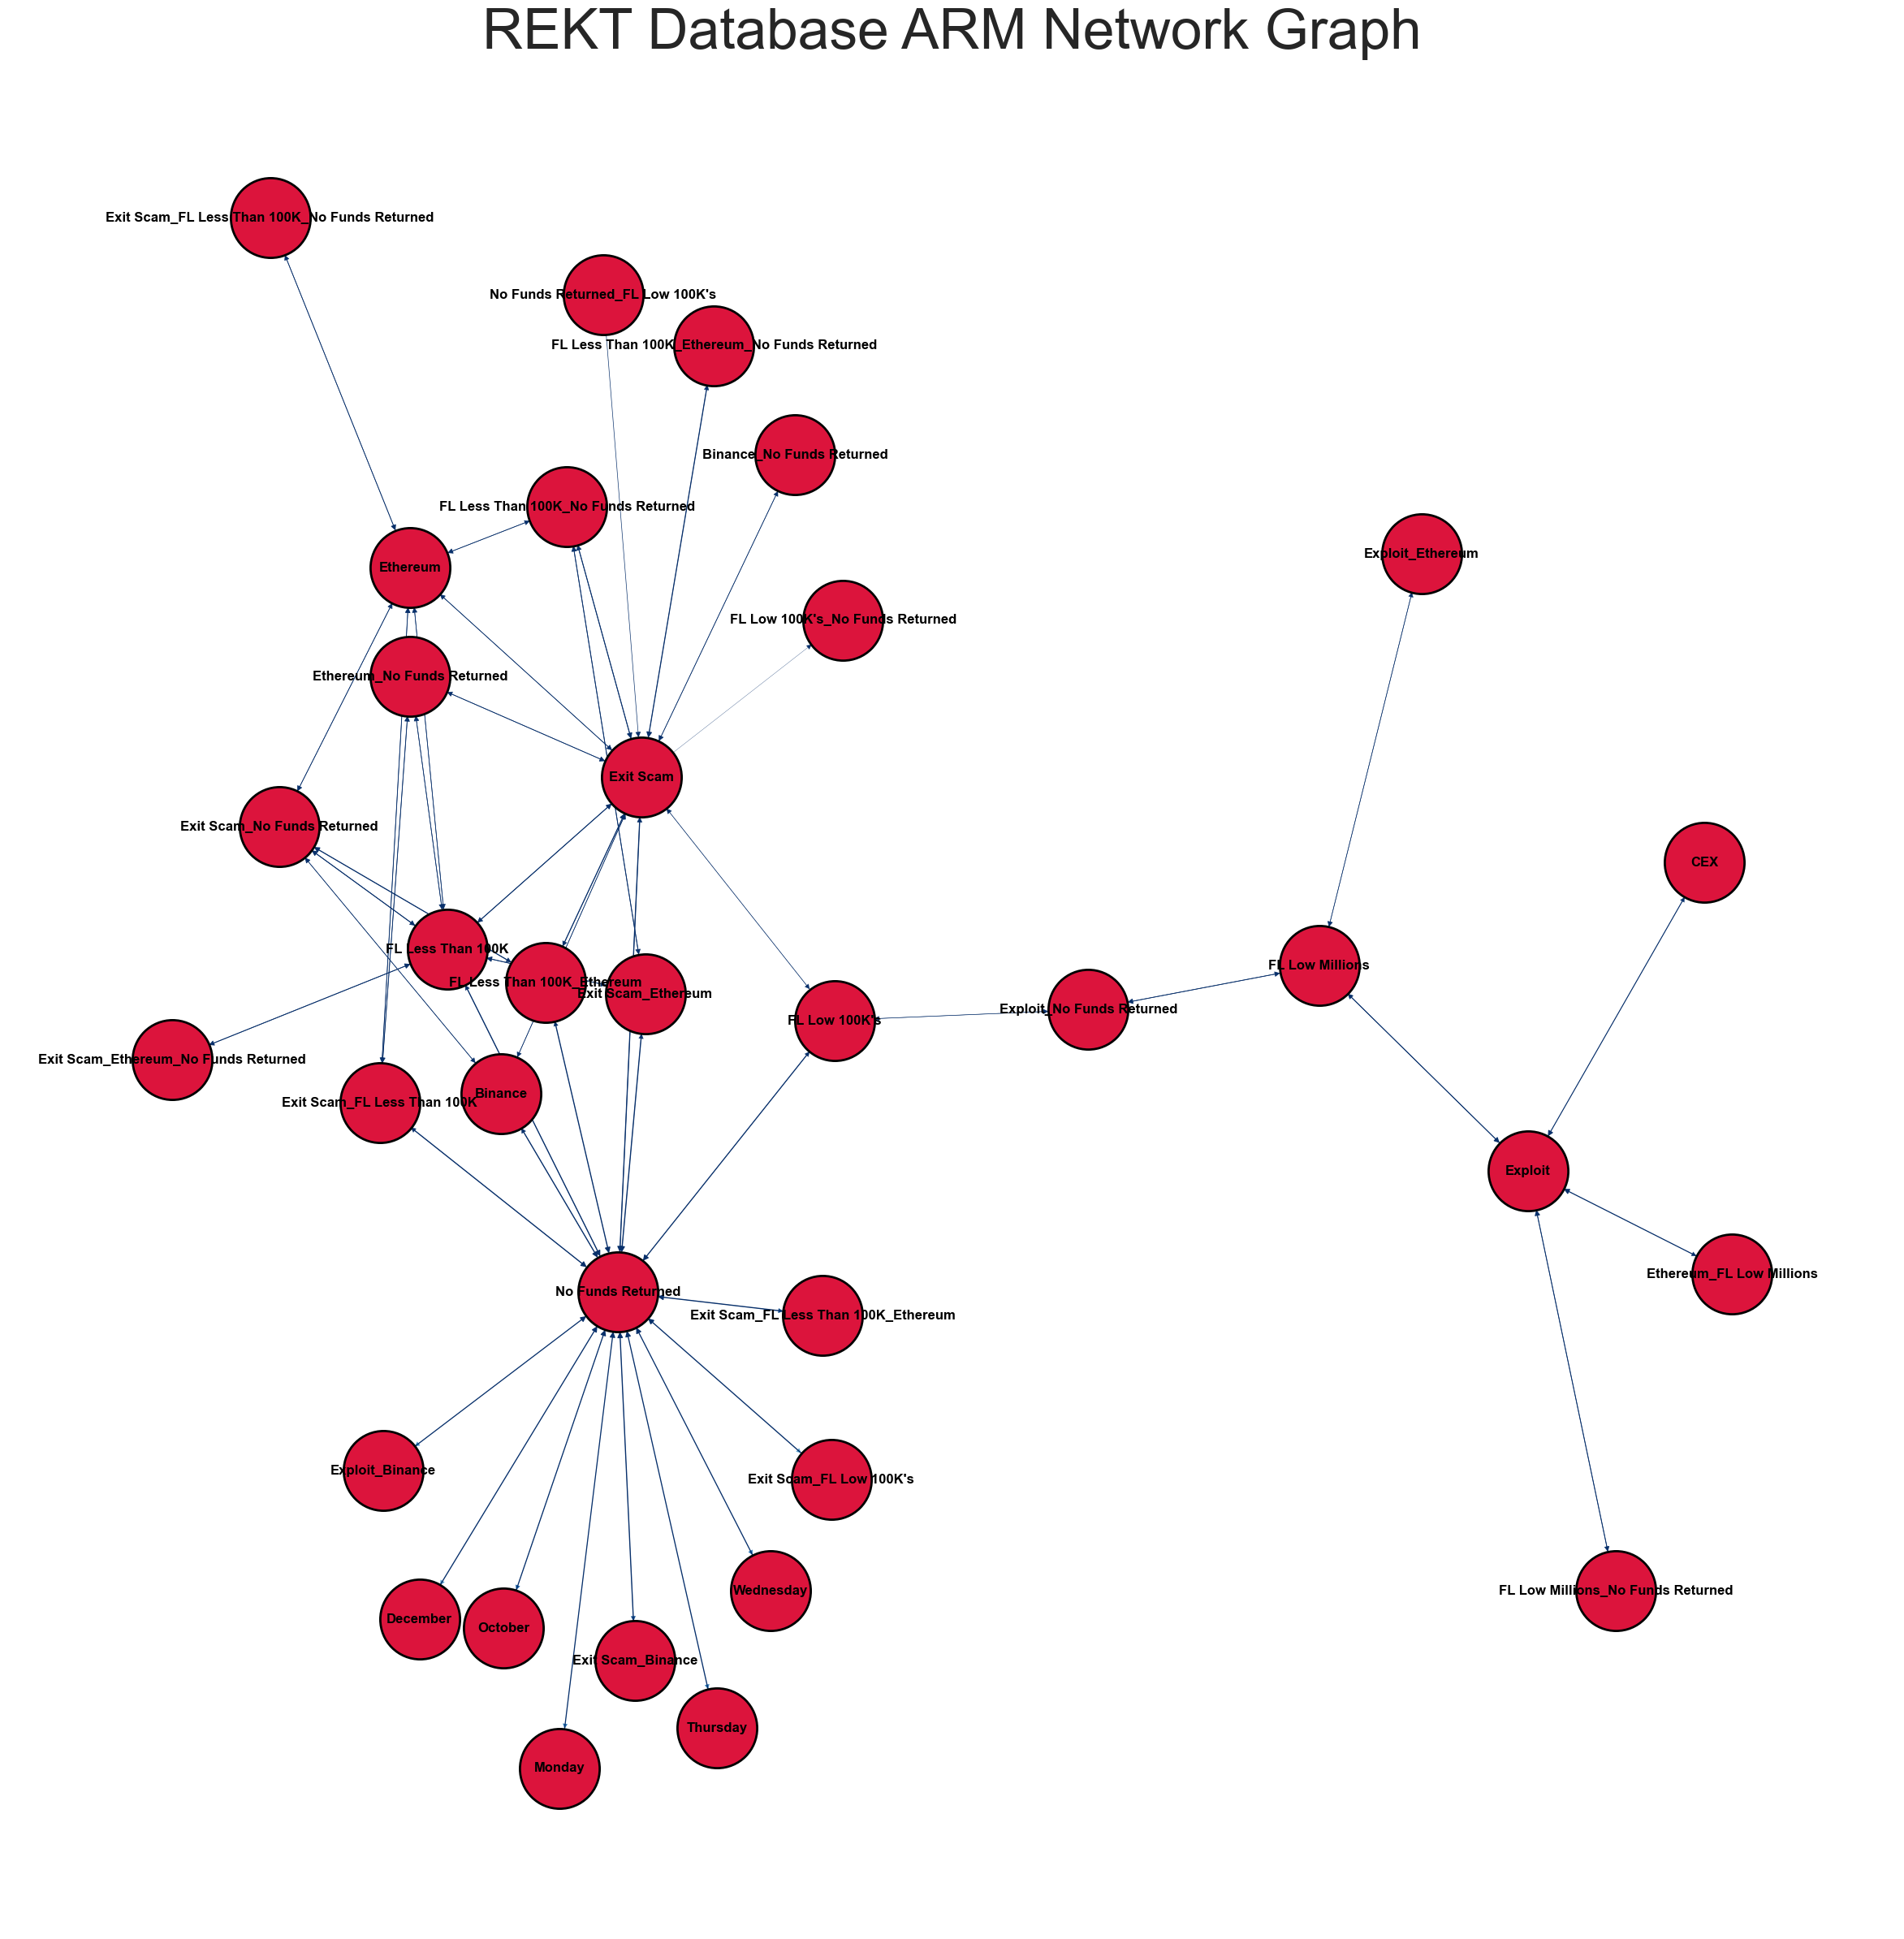

In [96]:
plot_network(G)

According to the above NetworkX graph and table of metrics, we see that 27 rules were generated with lift > 1 and support as well as confidence thresholds set to 10%. Most rules were formed for no funds returned (USD). A confidence threshold higher than 10% eliminates the date time features, which means that rules including date time item-sets get pruned due to their low associations with funds lost and returned. 

The graph provides insights about the Ethereum, Binance, and CEX cryptocurrency chains/latforms losing funds in the low 100 thousand's ($100,000 to $500,000) and low millions ($1,000,000 to $500,000,000) that led to no funds being returned. Moreover, Ethereum is closely associated with Exit Scams, comprising Honeypot attacks, Rugpull attacks, and Abandoned scams. In terms of funds lost for Ethereum in Exit Scams, the amount lost is less than USD 100,000. However, Ethereum loses funds in the low millions in Exploit attacks, comprising Access Control, Flash Loan Attacks, and Phishing! CEX is closely related to Exploit attacks resulting in funds lost in the low millions and no funds being returned. Binance, like Ethereum, is associated to both Exit Scams and Exploit attacks resulting in no funds being returned. 

Because no funds returned is a majority category of the data (almost 90%), we obtained these rules that were dominated with no funds returned. In terms of the datetime features, weekends are more likely to be associated with attacks than weekdays are. Let's see what other insights can be generated if we filter out values where no funds were returned...

## Apriori Algorithm After Filtering No Funds Returned Values

### Filtering

In [100]:
df_arm_flitered = df_arm.query("funds_returned_USD_discretized != 'No Funds Returned'")
df_arm_flitered.to_csv("df_arm_filt.csv", index=False, header=None) 
df = pd.read_csv("df_arm_filt.csv", header=None)
print(df.shape)

(65, 6)


### Dataframe to Transactions/Records

In [111]:
records = []
for i in range(len(df)):
    records.append([str(df.values[i,j]) for j in range(len(df.columns))])

### Performing Apriori Algorithm on Filtered Data (Funds Returned > USD 0)

In [125]:
association_rules = apriori(records, min_support=0.05, min_confidence=0.05, min_lift=2, min_length=2)
association_results = list(association_rules)

for item in association_results:
    
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])
    
    #second index of the inner list
    print("Support: " + str(item[1]))
    
    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

result_df = reformat_results(association_results)
print("Results\n",len(association_results))

Rule: August -> Tuesday
Support: 0.06153846153846154
Confidence: 0.4
Lift: 2.1666666666666665
Rule: Friday -> CEX
Support: 0.06153846153846154
Confidence: 0.36363636363636365
Lift: 2.1487603305785123
Rule: January -> CEX
Support: 0.06153846153846154
Confidence: 0.36363636363636365
Lift: 3.3766233766233764
Rule: FR High 100K's -> FL High 100K's
Support: 0.06153846153846154
Confidence: 0.6666666666666666
Lift: 8.666666666666666
Rule: FL Less Than 100K -> FR Less Than 100K (>0)
Support: 0.06153846153846154
Confidence: 1.0
Lift: 10.833333333333332
Rule: FR Low 100K's -> FL Low 100K's
Support: 0.1076923076923077
Confidence: 0.875
Lift: 5.6875
Rule: January -> Monday
Support: 0.06153846153846154
Confidence: 0.5714285714285714
Lift: 4.642857142857142
Rule: Saturday -> October
Support: 0.06153846153846154
Confidence: 0.5714285714285714
Lift: 3.714285714285714
Rule: Exploit -> August
Support: 0.06153846153846154
Confidence: 0.4
Lift: 2.1666666666666665
Rule: Exploit -> Friday
Support: 0.0615384

In [126]:
G = convert_to_network(result_df)

                                     rhs  \
0                               [August]   
1                              [Tuesday]   
2                                  [CEX]   
3                               [Friday]   
4                                  [CEX]   
..                                   ...   
61             [Monday, FR Low Millions]   
62  [Exploit, Ethereum, FL Low Millions]   
63  [Exploit, FR Low Millions, Ethereum]   
64    [Exploit, Monday, FL Low Millions]   
65    [Exploit, FR Low Millions, Monday]   

                                     lhs      supp      conf  supp x conf  \
0                              [Tuesday]  0.061538  0.400000     0.024615   
1                               [August]  0.061538  0.333333     0.020513   
2                               [Friday]  0.061538  0.363636     0.022378   
3                                  [CEX]  0.061538  0.363636     0.022378   
4                              [January]  0.061538  0.363636     0.022378   
..       

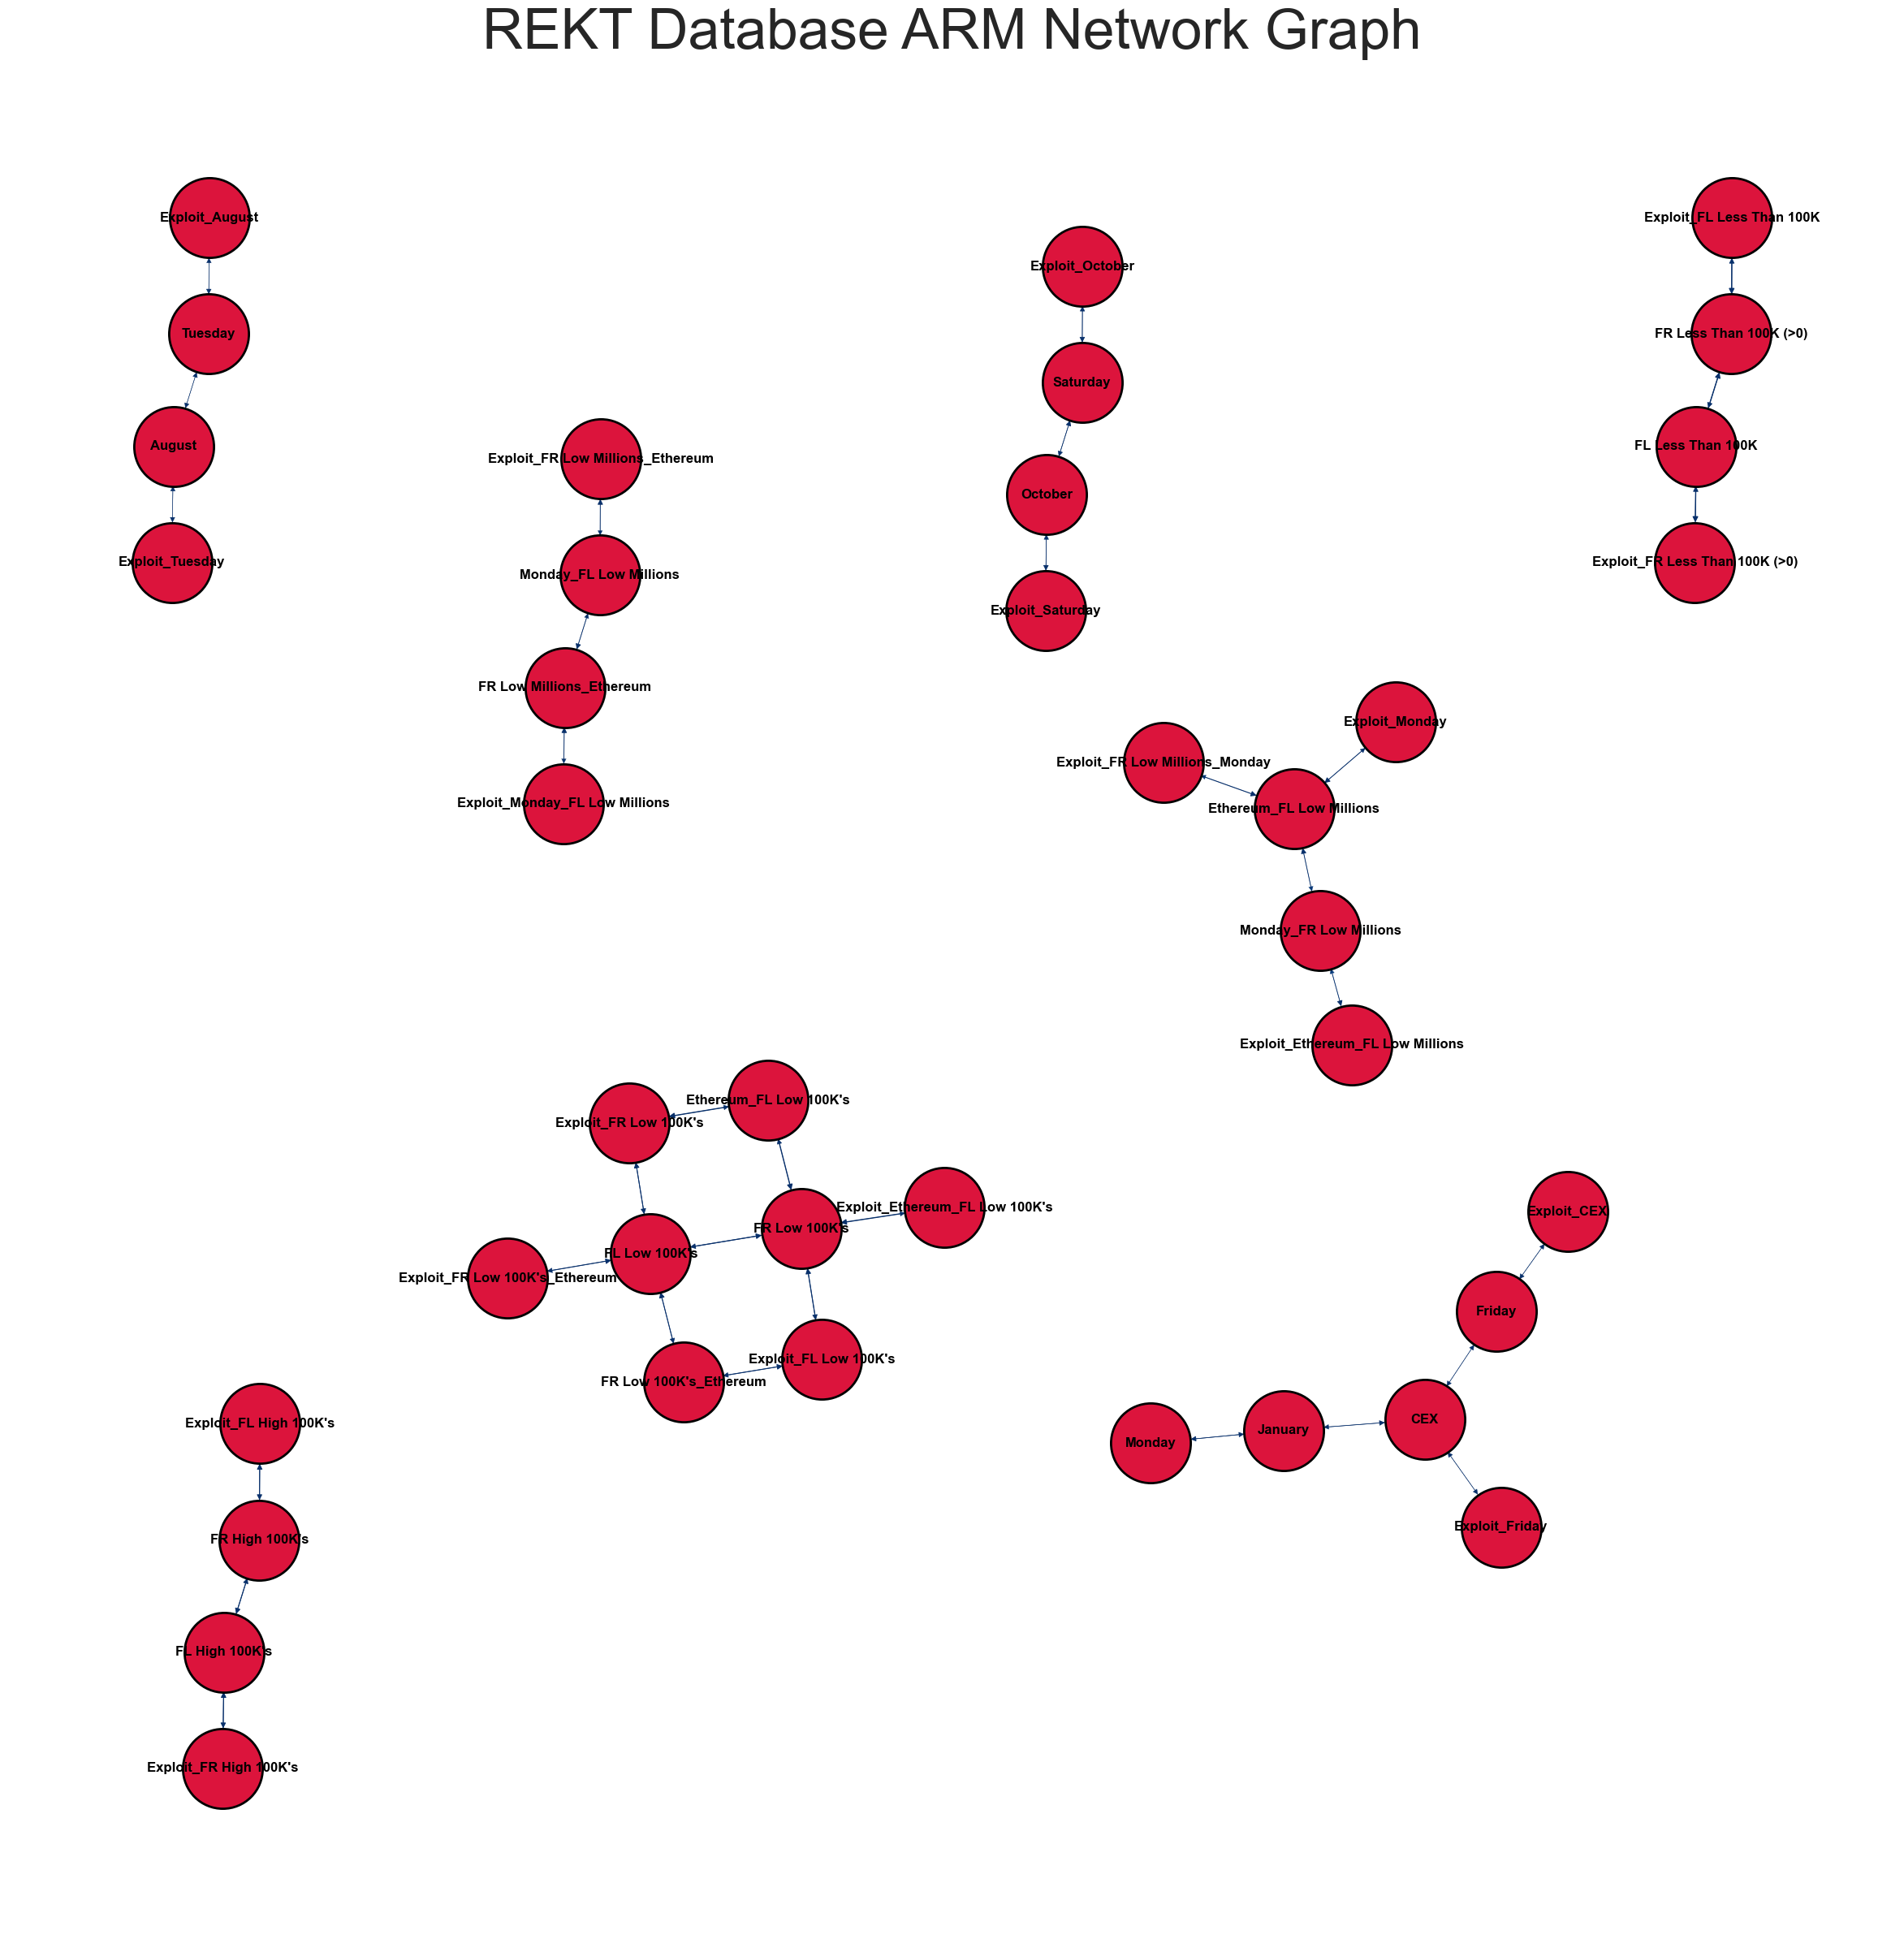

In [127]:
plot_network(G)

After performing the Apriori Algorithm, comprising support and confidence thresholds of 5% and lift threshold of 2 (closely dependent associations) on the filtered dataset, the network graph goes deeper into conveying associations with Exploit attacks. This signifies that majority of no funds returned values correspond to Exit Scams! Exploit attacks that resulted in either funds being lost in the high 100K's ($500,000 to $1,000,000) or less than 100K (but greater than $0), also resulted in similiar amounts of funds being returned respectively. We also get a better insight of weekdays and months associated with Exploit attacks. Exploit attacks that occurred in October were closely associated to weekends and attacks that occurred in August were closely associated to weekdays. The insights for Ethereum largely remain the same from the previous graph, but we obtain a better understanding of Exploit attacks on the CEX platform. Attacks on CEX are closely related to the month of January with Mondays and Fridays being the days associated with those attacks in January. 

# Conclusions

To wrap up, we found that attacks that were Exploits (Access Control, Flash Loan Attacks, and Phishing) were generally linked to the Ethereum chain and lost as well as recovered funds in the low millions (USD). The CEX cryptocurrency platform too was related to exploit attacks and were able to recover funds in the low millions (USD). Exit Scams comprising Honeypot attacks, Rugpull attacks, and Abandoned scams, on the other hand, were attacks that generally resulted in funds lost in the low millions (USD) but not being able to recover any funds. Moreover, exit scam attacks had a lower association with the other item sets in the dataset compared to that of exploit attacks. Exploit attacks were common on weekends rather than weekdays. Our dataset was conducive to running the Apriori Algorithm on it; however, a larger dataset would take more time train on and may result in more insignificant rules to filter from. 

# References

“Association Rule Learning.” Wikipedia. Wikimedia Foundation. Accessed December 1, 2022. https://en.wikipedia.org/wiki/Association_rule_learning. 

“Association Rules and the Apriori Algorithm: A Tutorial.” KDnuggets. Accessed December 1, 2022. https://www.kdnuggets.com/2016/04/association-rules-apriori-algorithm-tutorial.html. 
